# Speckle project documentation (fresh)

## Enter information:

In [1]:
video_time_length=120 #s
video_frame_numbers=1141 #frames
imgname='300f_405_1.0p_725gain_2min_1141frames_fresh'
foldername='/Volumes/wwyyrx/Wenyun/Speckle/Temp_data_03112022/405_1.0p_725gain_2min_1141frames_fresh/'

## Imports

In [2]:
%cd /Users/wenyun/Desktop/python/DSHpy-master 

# 2. install the project/module
!python setup.py install

# 3. Add the project directory to the path
import os, sys

sys.path.append(os.getcwd())

/Users/wenyun/Desktop/python/DSHpy-master
running install
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing DSH.egg-info/PKG-INFO
writing dependency_links to DSH.egg-info/dependency_links.txt
writing requirements to DSH.egg-info/requires.txt
writing top-level names to DSH.egg-info/top_level.txt
reading manifest file 'DSH.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'DSH.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib
running build_py
creating build/bdist.macosx-10.9-

In [45]:
import speckle
from speckle.inference.read_in_data import *
from speckle.inference.correlation_heatmap import *
from speckle.inference.calculating_tau import *
from speckle.inference.dedrift import *

In [4]:
from PIL import Image
import numpy as np
from ellipse import LsqEllipse
from matplotlib.patches import Ellipse
from skimage import io
import math
import pickle
import statistics
from statistics import mean
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks


from pandas import read_csv
from scipy.optimize import curve_fit

%matplotlib inline
import matplotlib.pyplot as plt
import os

import seaborn as sns
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import CorrMaps as CM

## Read in video

In [5]:
framespeed=video_time_length/video_frame_numbers

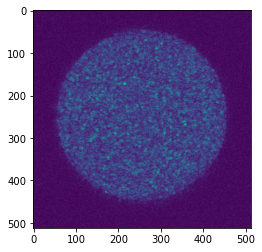

In [6]:
img=read_in_data(foldername,imgname)

## Dedrifting if necessary

In [7]:
particle_centers=foldername+"centers_fresh.csv"

dedrift_videos(img,particle_centers,foldername,imgname)

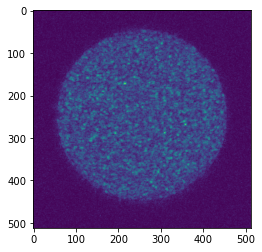

In [9]:
imgname=imgname+"_dedrifted"
img=read_in_data(foldername,imgname)

## setting up kernel and generate correlation maps

In [14]:
#info
kernel_size=9
laglist=list(range(1,100,1))
#test_ROI = [x,y,w,h]
testROI=[240,250,80,80]
tRange=None

In [15]:
## don't change please
def set_up_kernel(kernel_size):
    KernelSpecs = DSH.Kernel.Kernel()
    KernelSpecs.Initialize(shape=kernel_size, kernel_type='Gauss', params={'sigma':[kernel_size, kernel_size]}, padding=True)
    return KernelSpecs

def compute_correlation_maps(foldername, imgname, kernel, laglist, testROI=None, tRange=None):
    froot = os.path.join(foldername)
    fname = os.path.join(froot, imgname+'.raw')
    metadata_fname = os.path.join(froot, imgname+'.ini')
    
    mi_file = MI.MIfile(fname, metadata_fname)
    mi_file.OpenForReading()
    mi_file.Read(zRange=None, cropROI=None, closeAfter=False)
    mi_file.Close()
    
    position=str(testROI)+'_'+str(tRange)
    froot = os.path.join(foldername+imgname+'_'+position)
    #KernelSpecs.SetPadding(False)
    corrmap = CM.CorrMaps(mi_file, froot, laglist, kernel, imgRange=tRange, cropROI=testROI)
    
    cmap_list = corrmap.Compute(silent=False, return_maps=False)
    
def load_correlation_maps(foldername,imgname,testROI, tRange):
    froot = os.path.join(foldername+imgname+'_'+str(testROI)+'_'+str(tRange))
    corr_maps = CM.LoadFromConfig(os.path.join(froot, 'CorrMapsConfig.ini'), outFolder=froot)
    return corr_maps

In [16]:
kernel=set_up_kernel(kernel_size)

In [17]:
compute_correlation_maps(foldername, imgname, kernel, laglist, testROI, tRange)

Computing correlation maps:
  STEP 1: Loading images and computing average intensity...
  STEP 2: Computing contrast...
  STEP 3: Computing correlations...
     ...lag 1
     ...lag 2
     ...lag 3
     ...lag 4
     ...lag 5
     ...lag 6
     ...lag 7
     ...lag 8
     ...lag 9
     ...lag 10
     ...lag 11
     ...lag 12
     ...lag 13
     ...lag 14
     ...lag 15
     ...lag 16
     ...lag 17
     ...lag 18
     ...lag 19
     ...lag 20
     ...lag 21
     ...lag 22
     ...lag 23
     ...lag 24
     ...lag 25
     ...lag 26
     ...lag 27
     ...lag 28
     ...lag 29
     ...lag 30
     ...lag 31
     ...lag 32
     ...lag 33
     ...lag 34
     ...lag 35
     ...lag 36
     ...lag 37
     ...lag 38
     ...lag 39
     ...lag 40
     ...lag 41
     ...lag 42
     ...lag 43
     ...lag 44
     ...lag 45
     ...lag 46
     ...lag 47
     ...lag 48
     ...lag 49
     ...lag 50
     ...lag 51
     ...lag 52
     ...lag 53
     ...lag 54
     ...lag 55
     ...lag 56
     ...lag 5

In [18]:
corr_maps=load_correlation_maps(foldername,imgname,testROI, tRange)

## Calculate correlation heatmap

In [19]:
numberT_average=50
loadtRange = [0,200,round(200/numberT_average)]
t_range=range(0,200,round(200/numberT_average))
if testROI is None:
    heatmap_size=img.shape[1:3]
else:
    heatmap_size=[testROI[2],testROI[3]]

In [20]:
dump_list=[1]

In [ ]:
for i in dump_list:
    dump_heatmap(i,laglist,loadtRange,t_range, corr_maps,heatmap_size,numberT_average, foldername)

In [41]:
heatmap_lag=pickle.load(open(foldername+'_heatmap_decay_1_lagtime_'+str(numberT_average)+'avg.p', "rb"))

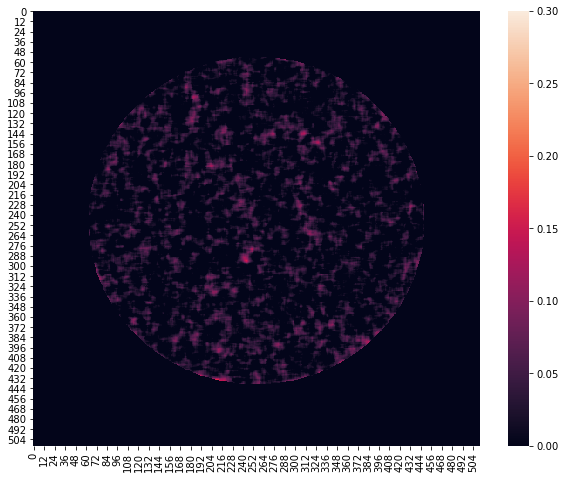

In [44]:
display_correlation_heatmaps(1, numberT_average,0, 0.3, foldername)

In [ ]:
## need to calculate radius mannually
line_intensity=[]
y=247
for x in range(0,500):
    line_intensity.append(heatmap_lag[y,x])
    if heatmap_lag[y,x]>0.3:
        print(heatmap_lag[y,x])
        print([y,x])
plt.plot(line_intensity,'.')

In [ ]:
center=[247,256] #[y,x]
radius=200
radius_outer=radius-7
scale_bar_position=[400,450] #[x,y]
scale_ratio=20.5155

In [ ]:
heatmap_masked=mask_heatmap(center,radius_outer,heatmap_lag, scale_bar_position, scale_ratio)

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap_masked,vmin=0, vmax=0.7)
plt.show()

In [ ]:
## dump raw data
pickle.dump(heatmap_masked, open(foldername+'_heatmap_masked_decay_1_lagtime_'+str(numberT_average)+'avg.p',"wb"))

## Compute single pixel decay constant tau

In [ ]:
numberT_average_tau=100
loadtRange_tau = [0,200,round(200/numberT_average_tau)]
t_range_tau=range(0,200,round(200/numberT_average_tau))
laglist_tau=list(range(5,900,5))
lagtime_tau= [element * framespeed for element in laglist_tau]

In [ ]:
def single_pixel_decay_constant(y,x,startidx=1,endidx=10):
    correlation_value=avg_correlation_single_px(corr_maps,[y,x],loadtRange_tau,t_range_tau,laglist_tau, laglist)
    plt.figure()
    plot_correlation_vs_lagtime(correlation_value,lagtime_tau)
    length=len(correlation_value)
    plateau=np.mean(correlation_value[length-int(length/9):length])
    print("plateau is:",plateau)
    plt.figure()
    decay_time, a,b =fit_exponential_decay(plateau,correlation_value,lagtime_tau,startidx,endidx, plotBoolean=True)
    reconstruct(lagtime_tau,plateau,correlation_value,a,b)

In [ ]:
y=5
x=5
single_pixel_decay_constant(y,x,startidx=1,endidx=10)

## Computing average correlation decay

In [21]:
# create pixel list
px_list_whole=[]
for y in range(testROI[3]):
    for x in range(testROI[2]):
        px_list_whole.append([y,x])

In [22]:
numberT_average_tau=50
loadtRange_tau = [0,200,round(200/numberT_average_tau)]
t_range_tau=range(0,200,round(200/numberT_average_tau))
laglist_tau=list(range(1,100,1))
lagtime_tau= [element * framespeed for element in laglist_tau]

In [25]:
def list_pixel_decay_constant(px_list,startidx=1,endidx=10):
    correlation_value=avg_correlation(corr_maps,px_list,loadtRange_tau,t_range_tau,laglist_tau, laglist)
    plt.figure()
    plot_correlation_vs_lagtime(correlation_value,lagtime_tau)
    length=len(correlation_value)
    plateau=np.mean(correlation_value[length-int(length/9):length])
    print("plateau is:",plateau)
    plt.figure()
    decay_time, a,b =fit_exponential_decay(plateau,correlation_value,lagtime_tau,startidx,endidx, plotBoolean=True)
    reconstruct(lagtime_tau,plateau,correlation_value,a,b)
    return correlation_value

[0, 0]
[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 5]
[0, 6]
[0, 7]
[0, 8]
[0, 9]
[0, 10]
[0, 11]
[0, 12]
[0, 13]
[0, 14]
[0, 15]
[0, 16]
[0, 17]
[0, 18]
[0, 19]
[0, 20]
[0, 21]
[0, 22]
[0, 23]
[0, 24]
[0, 25]
[0, 26]
[0, 27]
[0, 28]
[0, 29]
[0, 30]
[0, 31]
[0, 32]
[0, 33]
[0, 34]
[0, 35]
[0, 36]
[0, 37]
[0, 38]
[0, 39]
[0, 40]
[0, 41]
[0, 42]
[0, 43]
[0, 44]
[0, 45]
[0, 46]
[0, 47]
[0, 48]
[0, 49]
[0, 50]
[0, 51]
[0, 52]
[0, 53]
[0, 54]
[0, 55]
[0, 56]
[0, 57]
[0, 58]
[0, 59]
[0, 60]
[0, 61]
[0, 62]
[0, 63]
[0, 64]
[0, 65]
[0, 66]
[0, 67]
[0, 68]
[0, 69]
[0, 70]
[0, 71]
[0, 72]
[0, 73]
[0, 74]
[0, 75]
[0, 76]
[0, 77]
[0, 78]
[0, 79]
[1, 0]
[1, 1]
[1, 2]
[1, 3]
[1, 4]
[1, 5]
[1, 6]
[1, 7]
[1, 8]
[1, 9]
[1, 10]
[1, 11]
[1, 12]
[1, 13]
[1, 14]
[1, 15]
[1, 16]
[1, 17]
[1, 18]
[1, 19]
[1, 20]
[1, 21]
[1, 22]
[1, 23]
[1, 24]
[1, 25]
[1, 26]
[1, 27]
[1, 28]
[1, 29]
[1, 30]
[1, 31]
[1, 32]
[1, 33]
[1, 34]
[1, 35]
[1, 36]
[1, 37]
[1, 38]
[1, 39]
[1, 40]
[1, 41]
[1, 42]
[1, 43]
[1, 44]
[1, 45]
[1, 46]
[1, 

<Figure size 432x288 with 0 Axes>

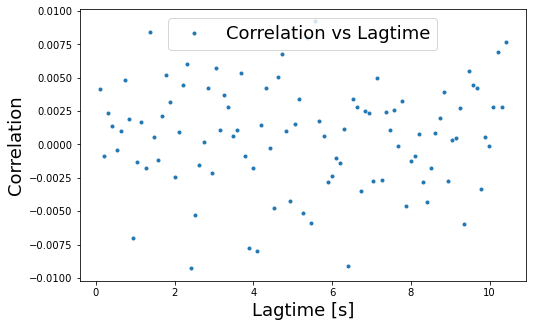

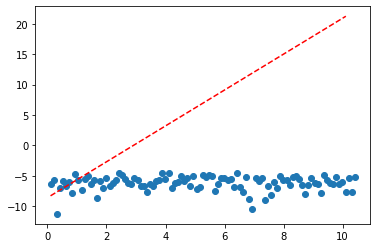

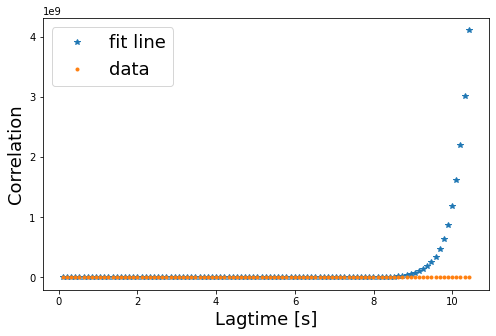

In [26]:
values=list_pixel_decay_constant(px_list_whole)

Text(0, 0.5, 'Correlation')

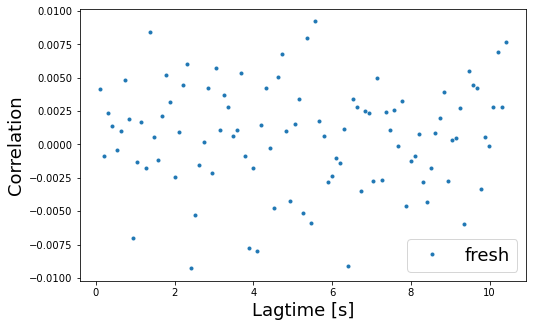

In [39]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_tau[0:100],values[0:100],'.',label='fresh')
plt.legend(fontsize=18)
plt.xlabel("Lagtime [s]",fontsize=18)
plt.ylabel("Correlation",fontsize=18)

In [35]:
pickle.dump(values, open(foldername+'correlation_values.p',"wb"))

In [36]:
pickle.dump(lagtime_tau, open(foldername+'lagtime.p',"wb"))